In [1]:
import os
import random
import time
from tqdm import tqdm
import pickle
import gensim
from collections import Counter


import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils import clip_grad_norm_
import torch.nn.functional as F
from torchinfo import summary
from torch.nn.utils.rnn import pad_sequence
from torchmetrics import F1Score
from torchmetrics.functional import f1_score, recall


import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report
from collections import defaultdict
from textwrap import wrap

import warnings
warnings.filterwarnings("ignore")

C:\Programs\miniconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
C:\Programs\miniconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] Не найдена указанная процедура
  warn(f"Failed to load image Python extension: {e}")


In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 8, 6

In [3]:
RANDOM_SEED = 1
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.random.manual_seed(RANDOM_SEED)
torch.cuda.random.manual_seed_all(RANDOM_SEED)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# LOAD DATA

In [4]:
train_data = pd.read_csv('./Оценить ревью/Train.csv')

In [5]:
train_data

,id,review_text,thumbs_up,score
0,0,It provides latest informations. Easy to use. ...,0,5
1,1,Good service.,0,4
2,2,Looks great and simple to use.,0,4
3,3,"Clear stats, everthing you need to know at a g...",0,4
4,4,Very good app,0,5
...,...,...,...,...
127628,127628,5yr/ longer timeframe charts please.,1,2
127629,127629,My morning app.,0,5
127630,127630,Changes in the portfolio isn't working,2,2
127631,127631,"Literal scum company, screwing over the little...",22,1


In [6]:
test_data = pd.read_csv('./Оценить ревью/Test.csv')

In [7]:
test_data

,id,review_text,thumbs_up
0,127633,I didnt expect it to be real. But just played ...,0
1,127634,"Ver convinent app, good information and news.",2
2,127635,Plots of info and stock proces for free,1
3,127636,"Easy to use, and very helpful for maintaining ...",52
4,127637,"Easy to use, lots of information.",1
...,...,...,...
31904,159537,"I lke Mint a lot, but for me it does not provi...",1
31905,159538,Why do you ask for my phone number?,0
31906,159539,"Great for keeping up with stocks, I use it daily.",0
31907,159540,gives relevant market news. easy to follow.,2


In [8]:
train_data.score.value_counts() # дизбаланс

5    69599
4    24384
1    17596
3     8856
2     7147
0       51
Name: score, dtype: int64

In [9]:
target_column = 'score'

In [10]:
train_df, non_train_df = train_test_split(train_data, test_size=0.2, random_state=RANDOM_SEED,stratify=train_data[target_column].to_list())

In [11]:
dev_df, test_df = train_test_split(non_train_df, test_size=0.5, random_state=RANDOM_SEED,stratify=non_train_df[target_column].to_list())

In [12]:
len(train_df), len(dev_df), len(test_df)

(102106, 12763, 12764)

# PROCESSING

In [13]:
class MyTokenizer():
    class Encoding:
        def __init__(self):
            super().__init__()
            tokens = list()
            ids = list()

    def __init__(self):
        self.index2token = list()
        self.token2index = dict()
        self.token2count = Counter()
        self.encoding = MyTokenizer.Encoding()
        self.reset()

    def add_sentence(self, sentence):
        for token in self.encode(sentence).tokens:
            self.add_token(token)

    def add_token(self, token):
        if token not in self.token2index:
            self.token2index[token] = len(self.index2token)
            self.token2count[token] += 1
            self.index2token.append(token)
        else:
            self.token2count[token] += 1
    
    def has_token(self, token) -> bool:
        return token in self.token2index

    def add_texts(self):
        sents_texts = train_df['review_text'].to_list()
        for sent in sents_texts:
            self.add_sentence(sent)

    def token_to_id(self, token):
        if token in self.token2index:
            return self.token2index[token]
        return self.token2index["<unk>"]

    def id_to_token(self, id_):
        if id_ in self.index2token:
            return self.index2token[id_]
        print('Нет такого id в словаре!')
    
    def is_empty(self):
        empty_size = 4
        return self.size() <= empty_size

    def shrink(self, n):
        # для сокращения словаря (выбирает n самых частых слов) (подаётся n)
        best_tokens = self.token2count.most_common(n)
        self.reset()
        for token, count in best_tokens:
            self.add_token(token)
            self.token2count[token] = count

    def reset(self):
        self.token2count = Counter()
        self.index2token = ["<pad>", "<bos>", "<eos>", "<unk>"]
        self.token2index = {token: index for index, token in enumerate(self.index2token)}

    def get_vocab(self):
        return self.token2index
    
    def get_vocab_size(self):
        return len(self.index2token)

    def encode(self, text: str): # sentence: str, max_length: int
#         indices = [self.get_index(token) for token in tokenize(sentence)]
#         indices = indices[:max_length-2]
#         indices.insert(0, self.token2index["<bos>"])
#         indices.append(self.token2index["<eos>"])
#         indices += [self.token2index["<pad>"] for _ in range(max_length - len(indices))]
#         text = str(text).strip()
#         return torch.tensor(indices)
        text = text.lower().strip()
        self.encoding.tokens = text.split(' ')
        self.encoding.tokens = [token.replace('.','').replace(',','') for token in self.encoding.tokens]
        self.encoding.ids = [self.token_to_id(token) for token in self.encoding.tokens]
        return self.encoding

    def decode(self, ids: torch.LongTensor):
        return print([self.index2token[id_] for id_ in ids].join(' '))

In [14]:
tokenizer = MyTokenizer()

In [15]:
tokenizer.add_texts()
#tokenizer.shrink(10000)

In [16]:
tokenizer.get_vocab_size()

44623

In [51]:
Word2Vec = gensim.models.KeyedVectors.load_word2vec_format('C:\\Users\\BIT\\Desktop\\education\\7sem\\NIR\\notebooks\\test_models\\GoogleNews-vectors-negative300.bin', binary=True)  

In [52]:
EMBEDDING_SIZE = 300

In [53]:
embedding_matrix = torch.zeros((len(tokenizer.index2token), EMBEDDING_SIZE))
embedding_matrix.shape

torch.Size([44623, 300])

In [54]:
for index, word in zip(tokenizer.token2index.values(),tokenizer.token2index.keys()):
    try:
        embedding_matrix[index] = torch.from_numpy(Word2Vec.get_vector(word).copy())
    except:
        embedding_matrix[index] = (-0.25 - 0.25) * torch.rand(EMBEDDING_SIZE) + 0.25

In [55]:
embedding_matrix[tokenizer.token2index['<pad>']] = torch.zeros(EMBEDDING_SIZE)

In [56]:
embedding_matrix[tokenizer.token2index['<unk>']] = (-0.25 - 0.25) * torch.rand(EMBEDDING_SIZE) + 0.25

In [57]:
del Word2Vec

# DATASET

In [17]:
class ReviewDataset(Dataset):

    def __init__(self, dataset, token2index, DEVICE):
        self.dataset = dataset['review_text'].values
        self.token2index = token2index
        self.length = dataset.shape[0]
        self.target = dataset[target_column].values
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        encoding = tokenizer.encode(self.dataset[index])
        tokens = encoding.tokens
        ids = torch.LongTensor(encoding.ids)
        y = self.target[index]
        return ids, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
        # он понадобится для DataLoader во время итерации по батчам
        ids, y = list(zip(*batch)) # zip делает кортёжи соотв. эл-в и они записываются в list
        padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
        y = torch.LongTensor(y).to(self.device)
        return padded_ids, y

In [18]:
BATCH_SIZE = 256

In [19]:
train_dataset = ReviewDataset(train_df, tokenizer.get_vocab(), device)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=BATCH_SIZE)

In [20]:
val_dataset = ReviewDataset(dev_df, tokenizer.get_vocab(), device)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=BATCH_SIZE)

# MODEL

In [232]:
class Model(nn.Module): # делаем свёртки на векторах
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes): # может быть словосочетания из 3 слов содержат достаточную информацию для классификации текста (например, по токсичности (3 слова грубых))
        super().__init__()
        #self.embeddings = nn.Embedding(vocab_size, embedding_dim=embed_size)
        self.embeddings = nn.Embedding.from_pretrained(embedding_matrix,freeze=False,padding_idx=0)
        self.dropout = nn.Dropout(p=0.4)
        self.cnn = nn.Sequential(
            nn.Conv1d(embed_size, hidden_size, kernel_size=3, padding=1, stride=2), # (на выходе batch_size x hiden_size x seq_le1) (размерность ядра - embed_size x kernel_size)
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            self.dropout,
            nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1, stride=2), # (на выходе batch_size x hiden_size x seq_le2) (размерность ядра - embed_size x kernel_size)
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            self.dropout,
            nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1, stride=2), # (на выходе batch_size x hiden_size x seq_le3) (размерность ядра - embed_size x kernel_size)
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1), # берёт максимум вдоль seq_le(столбцов), изменяя только последний канал (оставляет один столбец - эмбеддинг предложения) (batch_size x hidden_size (50) x 1)
            nn.Flatten(), # (batch_size x hidden_size x 1) -> (batch_size x hidden_size)
            self.dropout
        )
        self.cl = nn.Sequential(
            nn.Linear(hidden_size, num_classes) # (batch_size x hidden_size) -> (batch_size x num_classes)
        )
        

    def forward(self, x): # x - batch_size x seq_len (строки-предложения, которые являются списками индексов)
        x = self.embeddings(x)  # подаются индексы (кол-во seq_len) и им ставятся в соотв. эмбеддинги (batch_size, seq_len, embed_size)
        x = x.permute(0, 2, 1) # меняет размерности в соответсвующем порядке цифр (batch_size, embed_size, seq_le); x - батч столбцов-эмбеддингов соответсвующих слов в предложении
        x = self.cnn(x) #Conv-BN-RELU+Conv-BN-RELU+Conv-BN-RELU+AMaxPool
        prediction = self.cl(x)
        return prediction

In [233]:
NUM_EPOCHS = 5
NUM_CLASSES = len(train_data[target_column].value_counts().index) # len(data.YL1.unique()) CS
NUM_CLASSES

6

In [234]:
model = Model(tokenizer.get_vocab_size(), 300, 300, NUM_CLASSES)
optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss(weight=torch.Tensor([0.04,0.09,0.14,0.19,0.24,0.29]))

In [235]:
train_data.score.value_counts()/len(train_data)

5    0.545306
4    0.191048
1    0.137864
3    0.069386
2    0.055996
0    0.000400
Name: score, dtype: float64

In [236]:
model = model.to(device)
criterion = criterion.to(device)

In [237]:
train_losses = []
val_losses = []
train_f1s = []
val_f1s = []

for e in range(NUM_EPOCHS):
    train_epoch_loss = 0
    train_epoch_metric = 0
    model.train()
    print(f'\nstarting Epoch {e}')
    print('Training...')
    for i, (texts, labels) in enumerate(train_iterator):
        optimizer.zero_grad()
        prediction = model(texts)
        loss = criterion(prediction, labels)
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item()
        train_batch_metric = f1_score(prediction.long().detach().cpu().argmax(-1), labels.long().detach().cpu(), average='macro')
        train_epoch_metric += train_batch_metric
        if not (i + 1) % int(len(train_iterator)/5):
            print(f'Train loss: {train_epoch_loss/(i+1)}, Train f1: {train_epoch_metric/(i+1)}')

    train_f1, train_loss = train_epoch_metric / len(train_iterator), train_epoch_loss / len(train_iterator)
    train_losses.append(train_loss)
    train_f1s.append(train_f1)
    
    print('\nEvaluating on test...')
    val_epoch_loss = 0
    val_epoch_metric = 0
    model.eval()
    with torch.no_grad():
        for i, (texts, labels) in enumerate(val_iterator): 
            optimizer.zero_grad()
            prediction = model(texts)
            loss = criterion(prediction, labels)
            val_epoch_loss += loss.item()
            val_batch_metric = f1_score(prediction.argmax(-1).long().detach().cpu(), labels.long().detach().cpu(),average='macro')
            val_epoch_metric += val_batch_metric

            if not (i + 1) % int(len(val_iterator)/5):
                print(f'val loss: {val_epoch_loss/(i+1)}, val f1: {val_epoch_metric/(i+1)}')  

    val_f1, val_loss = val_epoch_metric / len(val_iterator), val_epoch_loss / len(val_iterator)
    val_losses.append(val_loss)
    val_f1s.append(val_f1)


starting Epoch 0
Training...
Train loss: 1.0587831992137282, Train f1: 0.26933358118979545
Train loss: 0.9402077231980577, Train f1: 0.3015346813288597
Train loss: 0.8886898308363644, Train f1: 0.32038995392186276
Train loss: 0.8526331120276753, Train f1: 0.33569874674670114
Train loss: 0.8327993296369721, Train f1: 0.3489734398407924

Evaluating on test...
val loss: 0.7095449805259705, val f1: 0.410838202848709
val loss: 0.6970347344875336, val f1: 0.4121362470312562
val loss: 0.6971491515636444, val f1: 0.40577368616953524
val loss: 0.7026090189814568, val f1: 0.40611139851327493
val loss: 0.7019562554359436, val f1: 0.40647239916797573

starting Epoch 1
Training...
Train loss: 0.6783115931704075, Train f1: 0.43797001683806236
Train loss: 0.6757048719291445, Train f1: 0.4375840619136015
Train loss: 0.6754334606701815, Train f1: 0.4383031594053571
Train loss: 0.6797379251522354, Train f1: 0.44006121919254454
Train loss: 0.6790496771848654, Train f1: 0.44083667598574733

Evaluating on

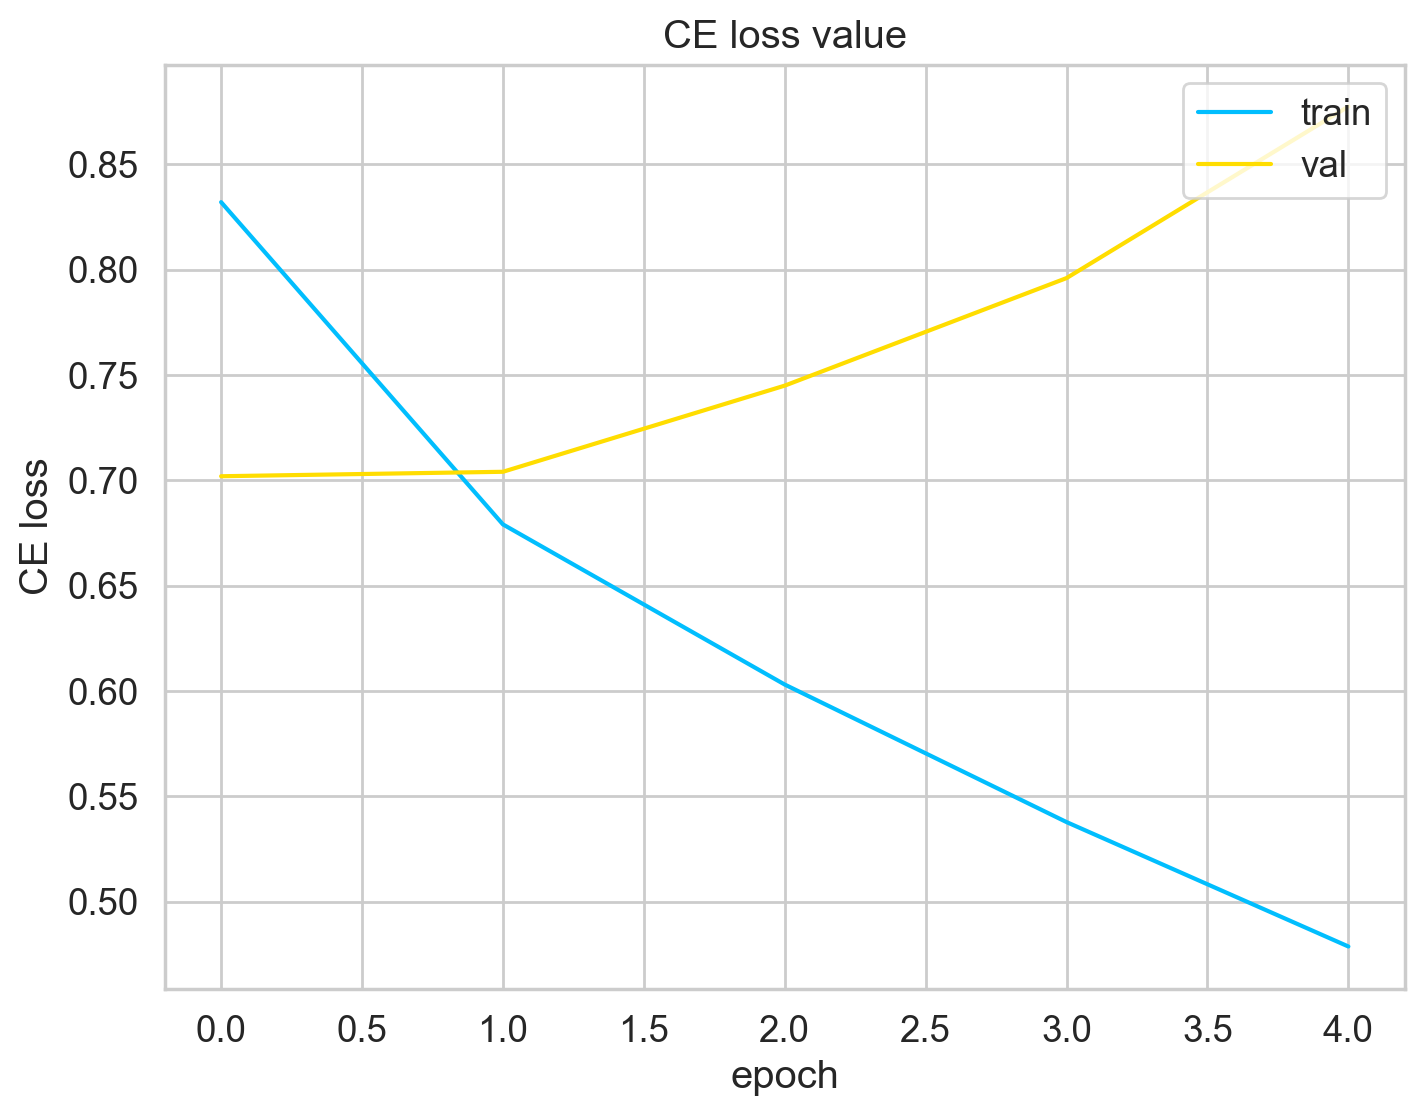

In [238]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('CE loss value')
plt.ylabel('CE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

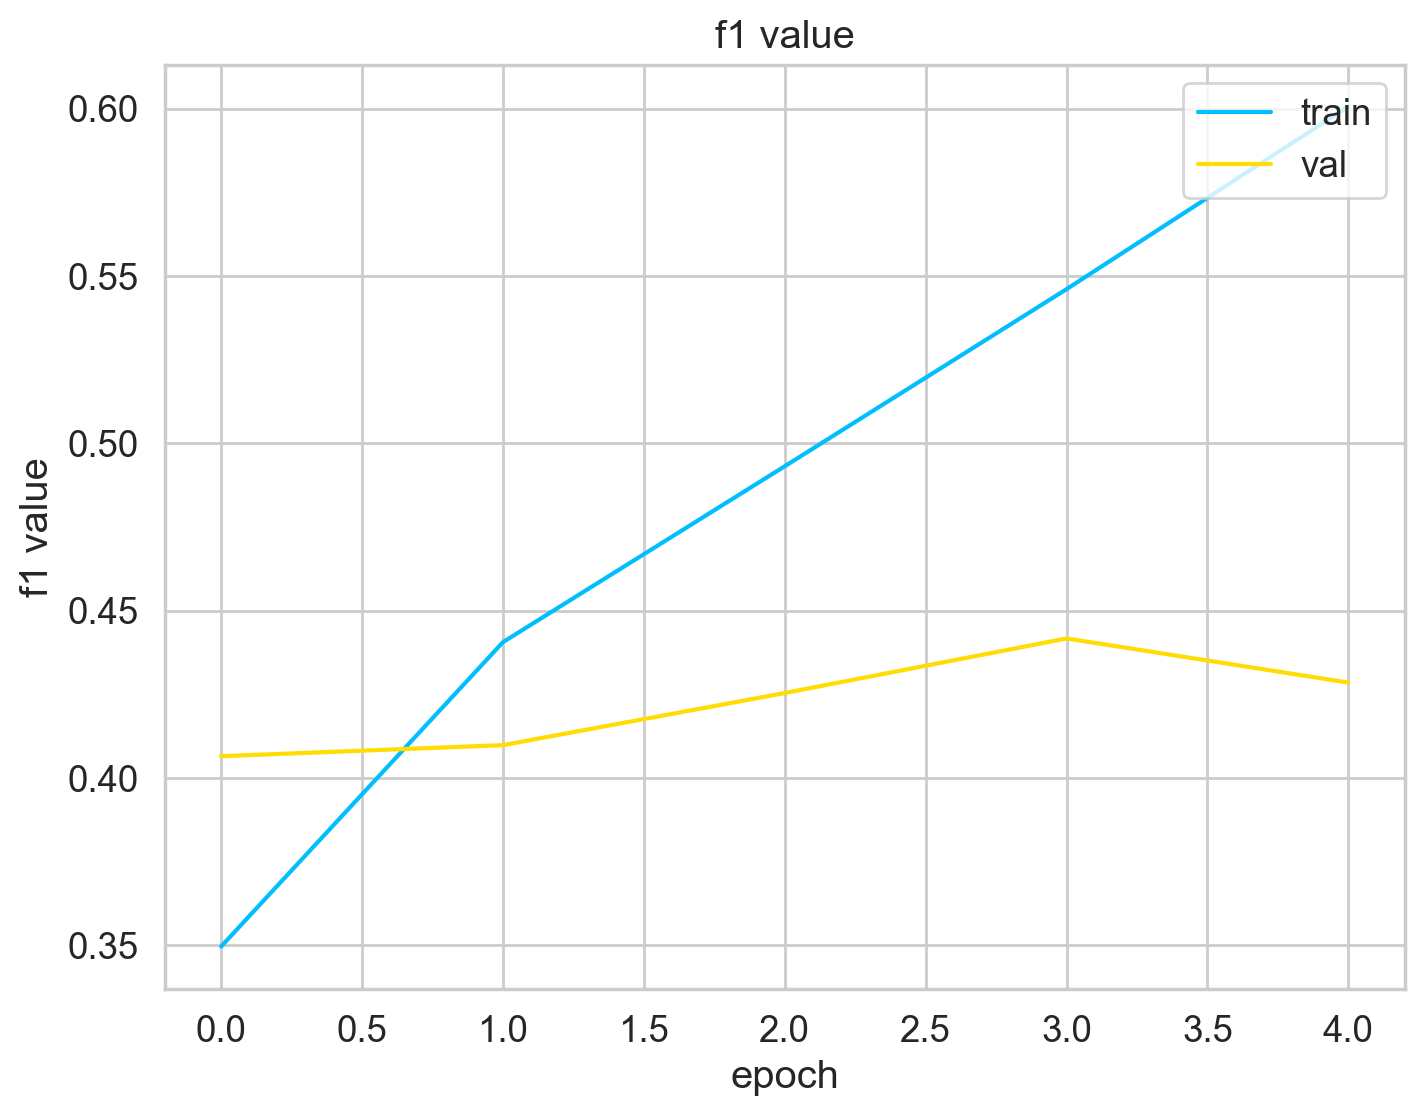

In [239]:
import matplotlib.pyplot as plt
plt.plot(train_f1s)
plt.plot(val_f1s)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# PREDICT

In [240]:
test_tokens = test_data.apply(lambda x: torch.LongTensor(tokenizer.encode(x.review_text).ids),axis=1).to_list()

In [241]:
model.eval()
test_answers = []
for el in test_tokens:
    test_answers.append(model(el.unsqueeze(0).cuda()).argmax(-1))

In [242]:
test_answers = [el.cpu().item() for el in test_answers]

In [243]:
my_sub = pd.DataFrame({'score':test_answers})

In [244]:
my_sub.to_csv('MySubmission.csv',index=False)